The following script is used to make a map and a chart showing station distribution over time for the QA/QC training subset of 937 stations. This training subset of stations was selected based on a representative sample of elevation, temperature, precipitation, and windspeed. Stations without time information in their station lists are not reflected in the time-based chart, but are included in the map.

In [1]:
# Import libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from io import BytesIO, StringIO
from datetime import datetime, timezone, date
import geopandas as gpd
import contextily as cx

In [2]:
# Function: plot station chart
def get_station_chart(bucket_name, directory):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3') # for lower-level processes
    
    # read in cleaned station list
    obj = s3_cl.get_object(Bucket = bucket_name, Key = "2_clean_wx/temp_clean_all_station_list.csv")
    body = obj['Body'].read()
    dfall = pd.read_csv(BytesIO(body), encoding='utf8')
    
    # read in qaqc training station list
    stns = pd.read_csv('../3_qaqc_data/qaqc_training_station_list.csv')
    
    dffull = dfall[dfall['era-id'].isin(stns['era-id'])]
    
    # Get period

    # Format dates in datetime format (this gets lost in import).
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # Fix nas
    ## Filter out rows w/o start date
    ## Note here: we lose MARITIME and NDBC networks.
    #print(dffull[dffull['network']=="MARITIME"])
    subdf = dffull.loc[~dffull['start-date'].isnull()].copy()

    ## Filter out non-cleaned rows
    subdf = subdf.loc[subdf['cleaned']!="N"].copy()
    
    # manually filter dates to >01-01-1980 and <today.
    # Timezones so far ignored here but we presume on the scale of month we can safely ignore them for the moment.
    # Note!: This implicitly assumes stations w/o end date run until present. 

    subdf['start-date'] = subdf['start-date'].apply(lambda x: x if x > datetime(1980,1,1, tzinfo=timezone.utc) else datetime(1980,1,1, tzinfo=timezone.utc))
    subdf['end-date'] = subdf['end-date'].apply(lambda x: x if x < datetime.utcnow().replace(tzinfo=timezone.utc) else datetime.utcnow().replace(tzinfo=timezone.utc))
    
    # Get period of months for range of dates for each station
    subdf['period'] = [pd.period_range(*v, freq='M') for v in zip(subdf['start-date'], subdf['end-date'])]
    
    subdf = subdf[subdf.period.str.len()>0]
    subdf = subdf.reset_index(drop = True)

    out = subdf.explode('period').pivot_table(
        values = 'era-id', index = 'network', columns = 'period', aggfunc='count', fill_value=0)
    #out.columns = out.columns.strftime('%b-%y')
    
    return out


In [3]:
# Run functions - generate station chart
bucket_name = "wecc-historical-wx"
directory = "3_qaqc_wx/"

#station_list = get_station_list(bucket_name, directory) # Get combined station list.
out = get_station_chart(bucket_name, directory)

/tmp/ipykernel_19732/2519296628.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
/tmp/ipykernel_19732/2519296628.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)


s3.Object(bucket_name='wecc-historical-wx', key='3_qaqc_wx/qaqc_training_stations_over_time.png')

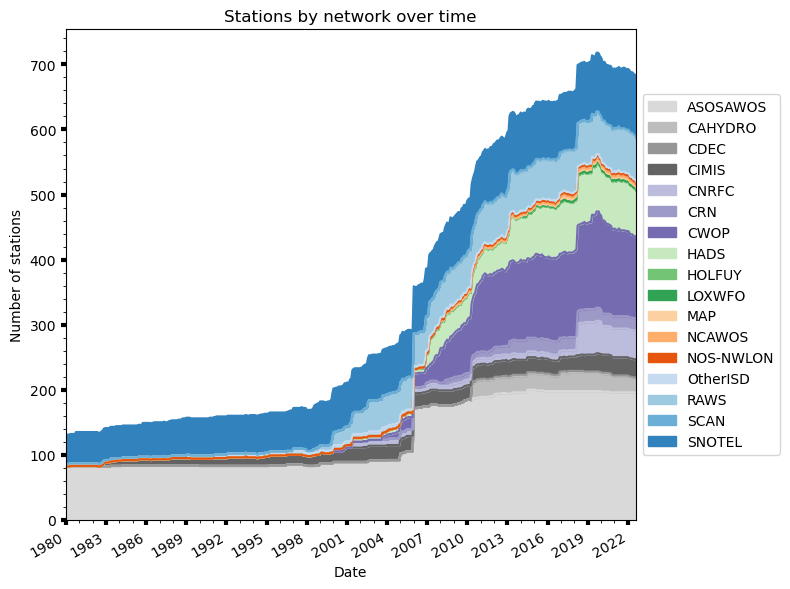

In [4]:
# Plot
outt = out.T.reset_index()

# Fix time component
outt['date'] = outt['period'].astype(str)
outt['date'] = pd.to_datetime(outt['date'])

# Plot parameters
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.facecolor'] = 'white'

# Subplot parameters
fig, ax = plt.subplots(figsize = (8, 6))
outt.plot.area(x = 'date', title = 'Stations by network over time', ax = ax, x_compat = True, cmap = 'tab20c_r') # Get area plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Fix legend 
ax.tick_params(labelcolor='black', labelsize='medium', width=3)
ax.set_facecolor('w')
ax.set_xlabel("Date")
ax.set_ylabel("Number of stations")

# Change axis bounds
ax.set_xlim([date(1980, 1, 1), date(2022, 8, 1)])

# Change tick marks
ax.minorticks_on()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(3))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(matplotlib.dates.YearLocator(1))

# Change y ticks
plt.locator_params(axis='y', nbins=12)
ax.yaxis.get_ticklocs(minor=True)

# Set x axis labels
# #plt.title("Stations Over Time By Network")
plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.8, right = 0.8)

# Save to AWS
img_data = BytesIO()
plt.savefig(img_data, format='png')
img_data.seek(0)

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
bucket.put_object(Body=img_data, ContentType='image/png', Key="3_qaqc_wx/qaqc_training_stations_over_time.png")

/tmp/ipykernel_1039/1882310704.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
/tmp/ipykernel_1039/1882310704.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)


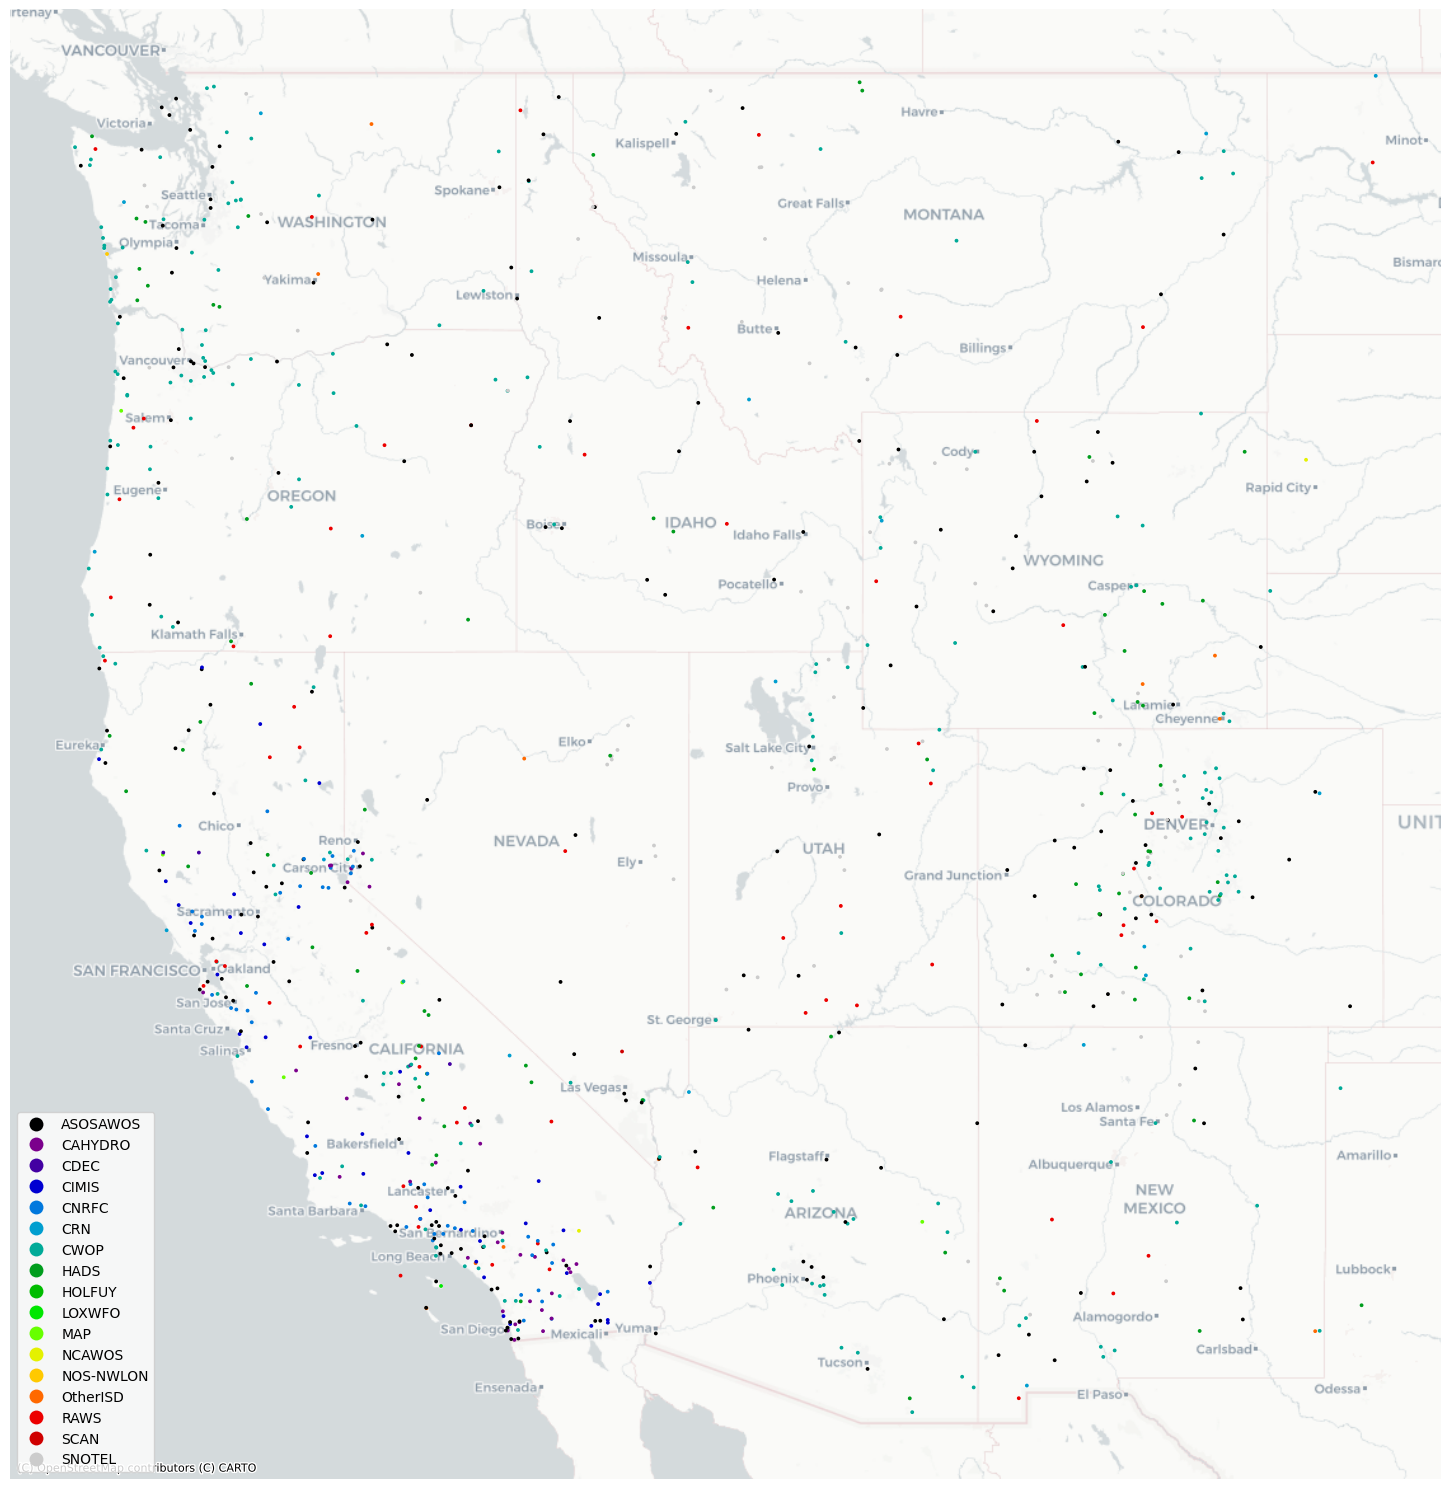

In [6]:
# Run function - generate station map

def get_station_map(bucket_name, directory, shapepath):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3') # for lower-level processes

    # read in cleaned station list
    obj = s3_cl.get_object(Bucket = bucket_name, Key = "2_clean_wx/temp_clean_all_station_list.csv")
    body = obj['Body'].read()
    dfall = pd.read_csv(BytesIO(body), encoding='utf8')
    
    # read in qaqc training station list
    stns = pd.read_csv('../3_qaqc_data/qaqc_training_station_list.csv')
    
    dffull = dfall[dfall['era-id'].isin(stns['era-id'])]

    # Get period

    # Format dates in datetime format (this gets lost in import).
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # Quality control.
    # Fix nas
    ## Filter out rows w/o start date
    subdf = dffull.loc[~dffull['start-date'].isnull()].copy()
    # Filter out rows without data between 1980 and now.
    subdf = subdf.loc[(subdf['start-date']<=datetime.utcnow().replace(tzinfo=timezone.utc)) & (subdf['end-date']>='1980-01-01')]
    
    # Make a geodataframe.
    gdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.longitude, subdf.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS
    
    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]

    # Use to clip stations
    us = us.to_crs(epsg = 3857)
    gdf_us = gdf_wm.clip(us)

    
    # Version 1 - full map
    ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="3_qaqc_wx/qaqc_training_station_map.png")
        
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state"
get_station_map(bucket_name, directory, shapepath = shapepath)